# History Analysis a Posteriori

## Setup

### Imports

In [1]:
from __future__ import print_function
from __future__ import division

# Standard Library, plus some Third Party Libraries
from pprint import pprint
from PIL import Image
from tqdm import tqdm
from typing import Union, Tuple

from functools import partial
from collections import Counter

import copy
import datetime
import h5py
import math
import os
import random
import shutil
import sys
import time
# import visdom

# Data Science and Machine Learning Libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns;
sns.set_theme(style="ticks")
# matplotlib.style.use('ggplot')

import numpy as np
import pandas as pd
import sklearn

from sklearn.model_selection import train_test_split

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# from piq import ssim
# from piq import psnr

# TorchVision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
from torchvision.utils import save_image

import torchsummary

# skimage
import skimage
import skimage.metrics as skmetrics
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

### Classes

In [2]:
class Config:  
    def __init__(self, **kwargs):
      for key, value in kwargs.items():
          setattr(self, key, value)
      pass
    pass

class PlotConfig(Config):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        pass
    pass

### Functions

#### Functions for Graphics related to Benford's Law

In [3]:
def get_leading_digit(a_number) -> int:
    """Return leading digit as integer from input data"""
    return int(str(a_number)[0])


def create_benford_graph(data, title = 'Benford\'s Law graph', label_bar_graph = 'bar chart', label_line_graph = 'line chart') -> pd.Series:
    """
    Create a graph for comparing Benford 's Law reference curve against the
    bar chart graphics obtained from input data.

    Parameters:
    -----------
    :data: iterable object-like such as np.ndarray, list.\n
    :title: str, (default: 'Benford\'s Law graph') graph's title.\n
    :label_bar_graph: str, (defautl: 'bar chart') data label for bar chart.\n
    :label_line_graph: str, (defautl: 'line chart') data label for line chart.

    Return:
    -------
    :digits_s: pandas.Series, containing (index , value) where index content are
               number in the range (0, 9) edges included, while value is a floating-point
               number representing the fraction in percentage of occurences of its relative leading
               digit.

    """

    # Generate data to be displayed, from imput data.
    s = pd.Series(data)
    s_result = s.map(get_leading_digit)

    data_counter = Counter(s_result)

    digits_counter_dict = dict(sorted(data_counter.items(), key = lambda xi: xi[0]))

    tot = sum(data_counter.values())

    digits_s = pd.Series(digits_counter_dict)
    digits_s = digits_s / tot * 100

    # Create new figure obj.
    fig = plt.figure()

    # Bar chart for generated data, from input data.
    ax = digits_s.plot(kind = 'bar', color = 'blue', label = label_bar_graph)
    # digits_s.plot(kind = 'line', color = 'red', ax = ax)

    # Compute Benford's law reference curve.
    x = np.linspace(1, 10)
    y = np.log10(1 + 1 / x) * 100
    


    # Line chart for generated data, from input data.
    if min(list(digits_counter_dict.keys())) == 1:
        x = np.linspace(0, 9)
        ax.plot(x, y, linestyle='dashed', color = 'black', label = 'Benford\'s reference')

        x = np.arange(1, 9+1)
        y = np.log10(1 + 1 / x) * 100

        x = np.arange(0, 9)
        ax.bar(x, y, color = 'orange', alpha = 0.5, lw=3, label = 'Benford\'s reference')

        y = digits_s[:]
    else:
        x = np.linspace(1, 10)
        ax.plot(x, y, linestyle='dashed', color = 'black', label = 'Benford\'s reference')

        x = np.arange(1, 9+1)
        y = np.log10(1 + 1 / x) * 100
        ax.bar(x, y, color = 'orange', alpha = 0.5, lw=3, label = 'Benford\'s reference')

        x = list(digits_counter_dict.keys())[1:]
        y = digits_s[1:]
    ax.plot(x, y, label = label_line_graph)

    # Enable picture metadata.
    plt.title(title)
    plt.legend()
    plt.show()
    
    # Return generate data, for eventually further investigation.
    return digits_s


def check_data(data_s):
    """Get right indeces for catch data to be displayed."""
    min_val = data_s.index.min()
    max_val = data_s.index.max()

    if min_val >= 0 and max_val <= 9:
        if min_val == 0:
            return 1, 10
        else:
            return 0, 10
    else:
        raise ValueError

def combine_series_benford(digits_a, digits_b, ax = None):

    # From pandas Series to pandas DataFrame to join them.
    start, stop = check_data(digits_a)
    digits_a_df = pd.DataFrame(digits_a[start:stop])

    start, stop = check_data(digits_b)
    digits_b_df = pd.DataFrame(digits_b[start:stop])
    
    digits_df = pd.concat([digits_a_df, digits_b_df], axis = 1)

    digits_df.columns = ['Ground Thruth', 'Predicted']
    digits_df.index = list(range(0, 9))

    # Produce graphics:
    # bar chart  - for showing occurences fractions in percentage.
    # line chart - for comparing against Benford's law reference curve.
    ax_bar = digits_df.plot(kind = 'bar', ax = ax)
    digits_df.plot(kind = 'line', ax = ax_bar)

    # Label x-axis for dispalying reasons.
    positions = list(range(0, 9))
    labels = [str(xx) for xx in list(range(1, 10))]

    # Compute Benford's law reference curve.
    x = np.linspace(1, 10)
    y = np.log10(1 + 1 / x) * 100

    # Check whether to add final plot to complex of images
    # or plot a single image.
    if ax is None:
        # Add Benford's law reference curve.
        x = np.linspace(0, 9)
        ax_bar.plot(x, y, linestyle='dashed', color = 'black', label = 'Benford\'s reference')

        x = np.arange(1, 9+1)
        y = np.log10(1 + 1 / x) * 100
        x = np.arange(0, 9)
        ax_bar.bar(x, y, color = 'orange', alpha = 0.5, lw=3, label = 'Benford\'s reference')

        _ = plt.xticks(positions, labels)
        plt.legend()
        plt.title('Benford Law - Images')
    else:
        # Add Benford's law reference curve.
        x = np.linspace(0, 9)
        ax.plot(x, y, linestyle='dashed', color = 'black', label = 'Benford\'s reference')

        x = np.arange(1, 9+1)
        y = np.log10(1 + 1 / x) * 100
        x = np.arange(0, 9)
        ax.bar(x, y, color = 'orange', alpha = 0.5, lw=3, label = 'Benford\'s reference')

        # ax.set_xticks(positions, labels)
        ax.set_xticklabels(labels)
        ax.legend()
        
    pass

def create_benford_series(data):
    
    # From full number to first leading digit
    s = pd.Series(data)
    s_result = s.map(get_leading_digit)

    # Compute occurences about each leading digit.
    data_counter = Counter(s_result)

    # Sort result.
    digits_counter_dict = dict(sorted(data_counter.items(), key = lambda xi: xi[0]))

    # Rescale data into fraction expressed as percentages w.r.t. 100 percent.
    tot = sum(data_counter.values())

    digits_s = pd.Series(digits_counter_dict)
    digits_s = digits_s / tot * 100

    # Return result.
    return digits_s

def combine_images_benford(image_a, image_b, ax = None, title = None):

    # From image to numpy array, flattened for 
    # processing reasons.
    arr_image_a = np.asarray(image_a).flat
    arr_image_b = np.asarray(image_b).flat

    # From numpy array to pandas Series for 
    # displaying reasons.
    series_image_a = create_benford_series(arr_image_a)
    series_image_b = create_benford_series(arr_image_b)
    
    # Combine data generated.
    combine_series_benford(series_image_a, series_image_b, ax = ax)
    return series_image_a, series_image_b

#### Functions for Graphics related to Metrices Scores Trends

In [4]:
# Data Science and Machine Learning Libraries
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')


def show_graphic_series_via_plot(
    series,
    image_path = "graphic_series.png", figsize=(10, 7),
    title = "Series Graphic",
    color='orange', label='data series',
    xlabel = 'pos', ylabel = 'value',
    show_min_max = False,
    ):

    plt.figure(figsize=figsize)

    # Add some annotation to graphics, about inpu data series.
    if show_min_max is True:

        # Show location of max value.
        max_value = series.max()
        max_pos = series.argmax()
        plt.annotate(f"epoch = {max_pos:.0f} | val = {max_value:.3f}", (max_pos, max_value))
        # plt.annotate(f"epoch = {max_pos:.0f}", (max_pos, 0))
        plt.vlines(x = max_pos,  ymin = 0, ymax = max_value,  linestyles='dashed')

        # Show location of middle pos value.
        middle_value = series[len(series)//2]
        middle_pos = len(series)//2
        plt.annotate(f"epoch = {middle_pos:.0f} | val {middle_value:.3f}", (middle_pos, middle_value))
        plt.vlines(x = middle_pos,  ymin = 0, ymax = middle_value,  linestyles='dashed')

        # Show location of min value.
        min_value = series.min()
        min_pos = series.argmin()
        plt.annotate(f"epoch = {min_pos:.0f} | val {min_value:.3f}", (min_pos, min_value))
        # plt.annotate(f"epoch = {min_pos:.0f}", (min_pos, 0))
        plt.vlines(x = min_pos,  ymin = 0, ymax = min_value,  linestyles='dashed')
        pass
    
    # Plot curve related to input data series.
    plt.plot(series, color=color, label=label)
    # plt.plot(val_loss, color='red', label='validataion loss')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(image_path)
    plt.show()
    pass

def show_graphic_series_via_ax(
    series,
    ax,
    image_path = "graphic_series.png", figsize=(10, 7),
    title = "Series Graphic",
    color='orange', label='data series',
    xlabel = 'pos', ylabel = 'value',
    show_min_max = False,
    ):

    # Add some annotation to graphics, about inpu data series.
    if show_min_max is True:
        # Show location of max value.
        max_value = series.max()
        max_pos = series.argmax()
        ax.annotate(f"epoch = {max_pos:.0f} | val {max_value:.3f}", (max_pos, max_value))
        ax.vlines(x = max_pos,  ymin = 0, ymax = max_value,  linestyles='dashed')

        # Show location of middle pos value.
        middle_value = series[len(series)//2]
        middle_pos = len(series)//2
        ax.annotate(f"epoch = {middle_pos:.0f} | val {middle_value:.3f}", (middle_pos, middle_value))
        ax.vlines(x = middle_pos,  ymin = 0, ymax = middle_value,  linestyles='dashed')

        # Show location of min value.
        min_value = series.min()
        min_pos = series.argmin()
        ax.annotate(f"epoch = {min_pos:.0f} | val {min_value:.3f}", (min_pos, min_value))
        ax.vlines(x = min_pos,  ymin = 0, ymax = min_value,  linestyles='dashed')
        pass

    # Plot curve related to input data series.
    ax.plot(series, color=color, label=label)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    pass

def show_graphic_series(
    series,
    image_path = "graphic_series.png", figsize=(10, 7),
    title = "Series Graphic",
    color='orange', label='data series',
    xlabel = 'pos', ylabel = 'value',
    ax = None,
    show_min_max = False,
    ):
    if ax is None:
        show_graphic_series_via_plot(
        series = series,
        image_path = image_path,
        title = title,
        figsize = figsize,
        color = color,
        label = label,
        xlabel = xlabel,
        ylabel = ylabel,
        show_min_max = show_min_max
    )
    else:
        show_graphic_series_via_ax(
        series = series,
        ax = ax,
        image_path = image_path,
        title = title,
        figsize = figsize,
        color = color,
        label = label,
        xlabel = xlabel,
        ylabel = ylabel,
        show_min_max = show_min_max
    )
    pass

def plot_series_graphic_by_config(series, config):
    show_graphic_series(
        series = series,
        image_path = config.image_path,
        title = config.title,
        figsize = config.figsize,
        color = config.color,
        label = config.label,
        xlabel = config.xlabel,
        ylabel = config.ylabel,
        ax = config.ax,
        show_min_max = config.show_min_max
    )
    pass

def plot_loss_graphic(loss_data, config):
    show_graphic_series(
        series = loss_data,
        image_path = config.image_path,
        title = config.title,
        figsize = config.figsize,
        color = config.color,
        label = config.label,
        xlabel = config.xlabel,
        ylabel = config.ylabel,
        show_min_max = config.show_min_max
    )
    pass

def plot_psnr_graphic(psnr_data, config):
    show_graphic_series(
        series = psnr_data,
        image_path = config.image_path,
        title = config.title,
        figsize = config.figsize,
        color = config.color,
        label = config.label,
        xlabel = config.xlabel,
        ylabel = config.ylabel,
        show_min_max = config.show_min_max
    )
    pass

## Run Notebook

### Globals

In [5]:
# Here, specify images path to be analysed.

image_path = '/content/test001.png'
image_path_ground_thruth = '/content/test001.png'

image_path_pred = '/content/predicted_image.png'

image_path_pred_gs = '/content/predicted_image.png'
image_path_pred_gs = '/content/predicted_image_grayscale.png'

### Show Images (Ground Thruth, Predicteds)

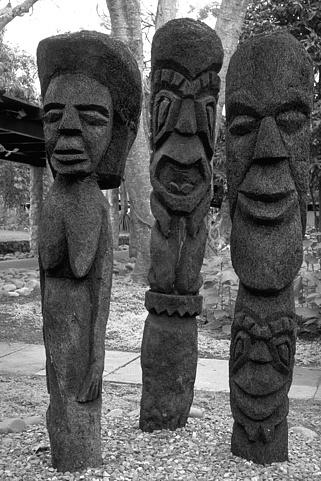

<Figure size 432x288 with 0 Axes>

In [6]:
from PIL import Image, ImageOps

img = None
if image_path != None and os.path.exists(image_path) and os.path.isfile(image_path):
    plt.figure()
    # im = Image.open(image_path).show()
    # im.show()
    img = Image.open(image_path)
    pass
img

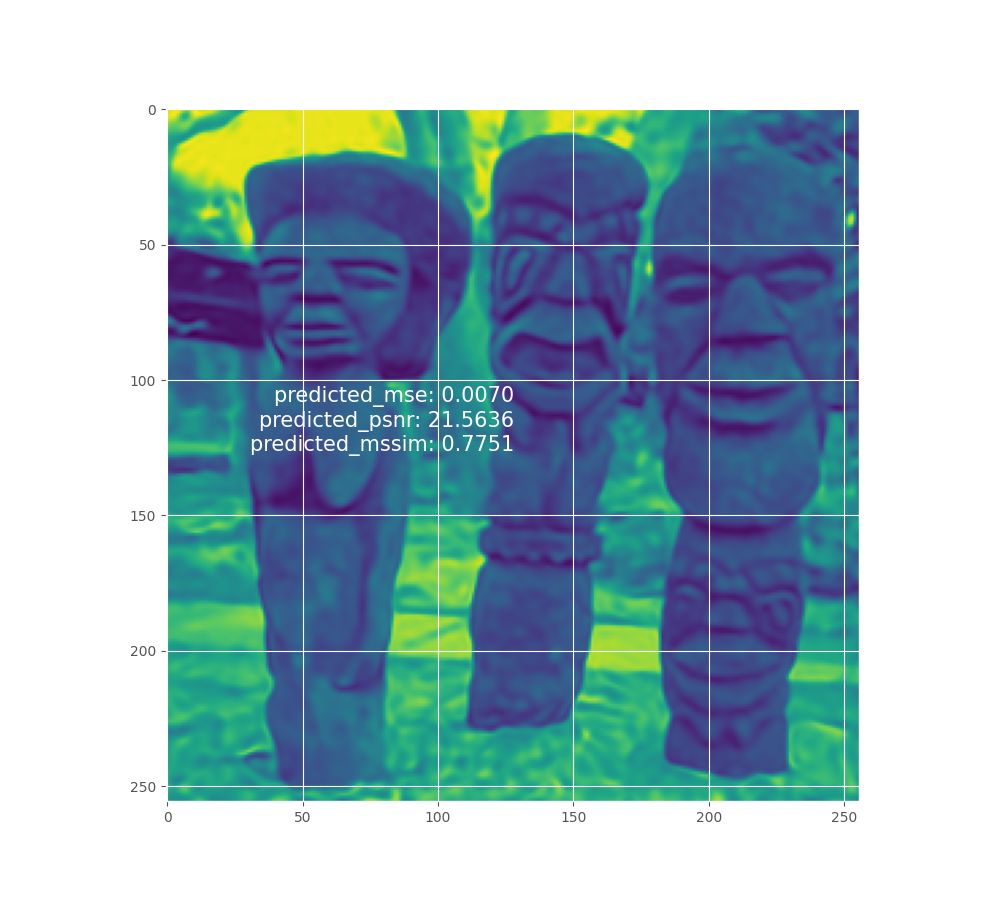

<Figure size 432x288 with 0 Axes>

In [30]:
predicted_image_path = '/content/predicted_images_w_metrics.png'
img = None
if predicted_image_path != None and os.path.exists(predicted_image_path) and os.path.isfile(predicted_image_path):
    plt.figure()
    img = Image.open(predicted_image_path)
    pass
img

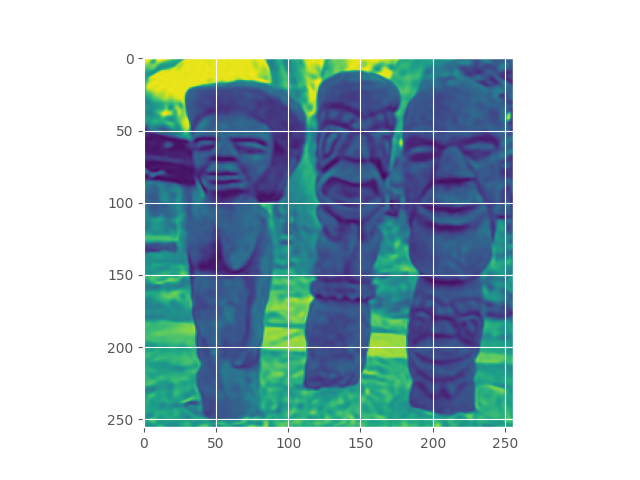

<Figure size 432x288 with 0 Axes>

In [7]:
predicted_image_path = '/content/predicted_image.png'
img = None
if predicted_image_path != None and os.path.exists(predicted_image_path) and os.path.isfile(predicted_image_path):
    plt.figure()
    img = Image.open(predicted_image_path)
    pass
img

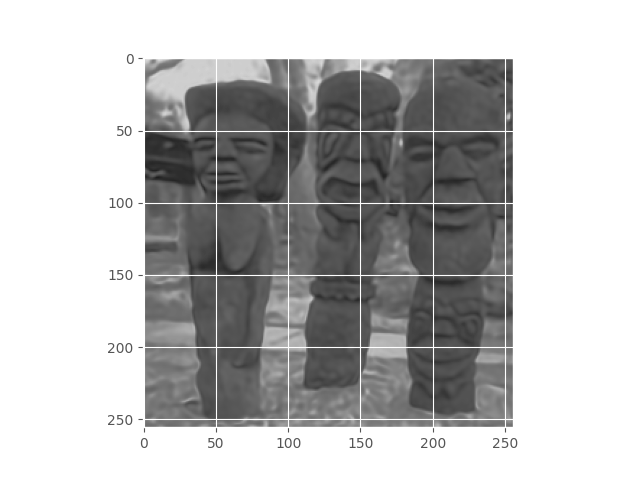

<Figure size 432x288 with 0 Axes>

In [8]:
img = None
if predicted_image_path != None and os.path.exists(predicted_image_path) and os.path.isfile(predicted_image_path):
    plt.figure()
    img = Image.open(predicted_image_path)
    img = ImageOps.grayscale(img)
    pass
img

### Fetch Data - History Analyses - (Brief Overview pandas DataFrame)


In [9]:
# Objects for better dispalying graphics details
# about metrices scores trends.

config_plot_loss = PlotConfig(
    image_path = None,
    figsize = (10, 7),
    title = "Train - Loss vs Epochs",
    xlabel = "Epochs",
    ylabel = "Loss",
    label = "train loss",
    color = "orange",
    show_min_max = True,
    ax = None
)

config_plot_psnr = PlotConfig(
    image_path = None,
    figsize = (10, 7),
    title = "Train - PSNR (db) vs Epochs",
    xlabel = "Epochs",
    ylabel = "PSNR (db)",
    label = "train PSNR (db)",
    color = "green",
    show_min_max = True,
    ax = None
)

config_plot_ssim = PlotConfig(
    image_path = None,
    figsize = (10, 7),
    title = "Train - SSIM vs Epochs",
    xlabel = "Epochs",
    ylabel = "SSIM",
    label = "train SSIM",
    color = "red",
    show_min_max = True,
    ax = None
)

In [10]:
# Fetch History data into numpy multi-dimensional ndarray
history_data_path = '/content/train_losses_final.txt'
data = np.loadtxt(history_data_path)

In [11]:
# Convert fetched data into pandas DataFrame
history_df = pd.DataFrame(data = data, columns = ['train_loss', 'train_psnr', 'train_ssim'])

In [12]:
# Details of pandas DataFrame object:
# check whether data values are not corrupted,
# such as missing values, if any.
history_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   train_loss  300 non-null    float64
 1   train_psnr  300 non-null    float64
 2   train_ssim  300 non-null    float64
dtypes: float64(3)
memory usage: 7.2 KB


In [13]:
history_df.head(5)

,train_loss,train_psnr,train_ssim
0,0.288646,5.396346,-0.003688
1,0.214251,6.690774,0.034964
2,0.199153,7.008121,0.049086
3,0.184765,7.333792,0.055266
4,0.164772,7.831174,0.061327


In [14]:
# basic stats
history_df.describe()

,train_loss,train_psnr,train_ssim
count,300.000000,300.000000,300.000000
mean,0.019262,18.638954,0.571871
std,0.029879,2.806486,0.184082
min,0.007003,5.396346,-0.003688
25%,0.008901,17.823331,0.485484
50%,0.011501,19.392537,0.630607
75%,0.016507,20.505493,0.713443
max,0.288646,21.547144,0.774132


### Show Trend Metrices

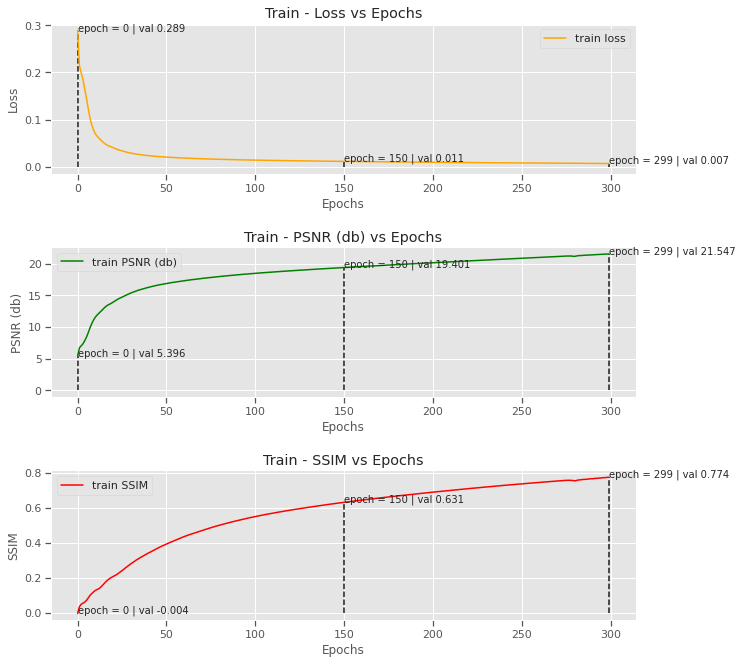

In [15]:
# Graphics about trend metrices recorded at training time.

fig, axes = plt.subplots(3, figsize=(10, 10))
fig.tight_layout(pad=5.0) 

config_plot_loss.ax = axes[0]
config_plot_psnr.ax = axes[1]
config_plot_ssim.ax = axes[2]

plot_series_graphic_by_config(history_df['train_loss'].values, config_plot_loss)
plot_series_graphic_by_config(history_df['train_psnr'].values, config_plot_psnr)
plot_series_graphic_by_config(history_df['train_ssim'].values, config_plot_ssim)

### Graphics analyses with Seaborn - Steamroller Approach ( a.k.a. Dummy Approach)

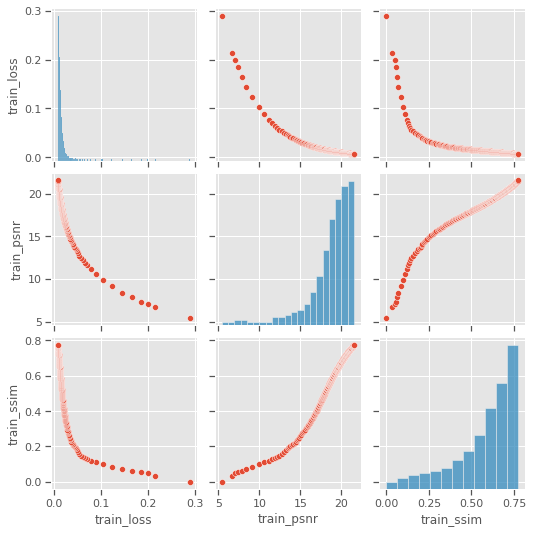

In [16]:
sns.pairplot(history_df)

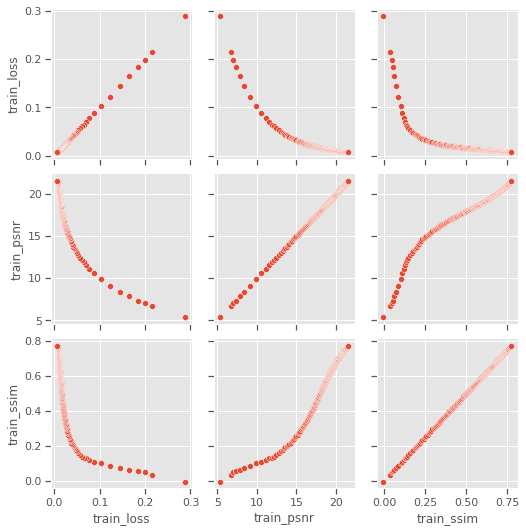

In [17]:
g = sns.PairGrid(history_df)
g.map(sns.scatterplot)

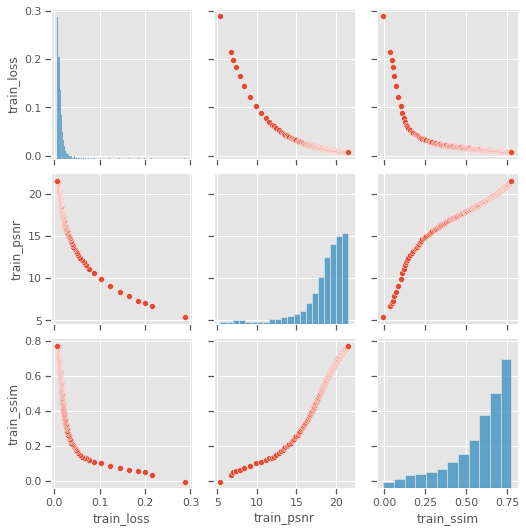

In [18]:
g = sns.PairGrid(history_df)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

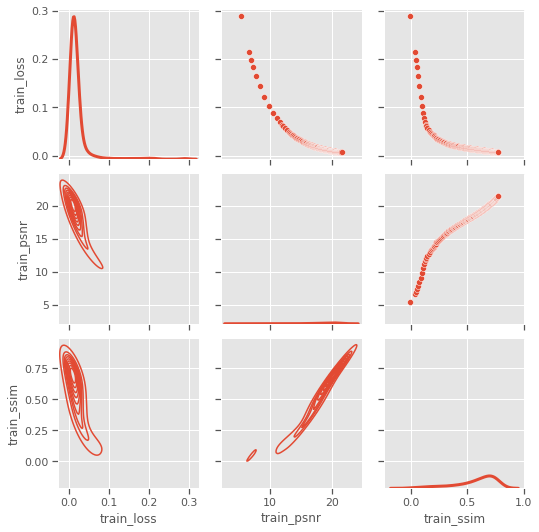

In [19]:
g = sns.PairGrid(history_df)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)

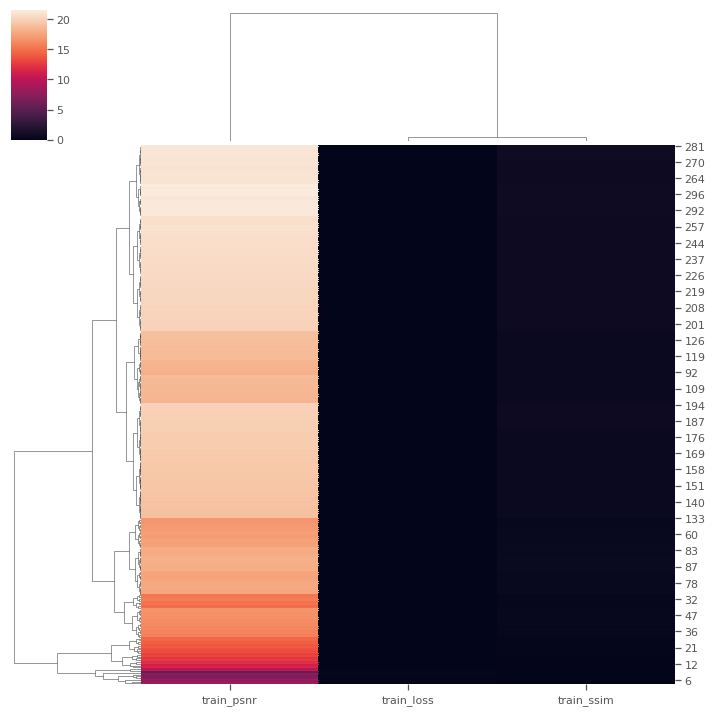

In [20]:
sns.clustermap(history_df)

### Benford's Law

#### Benford  Graphics per single images

In [21]:
# Compute Benford's law for Ground Thruth Image.

image_path_ground_thruth = '/content/test001.png'
img_ground_thruth = Image.open(image_path_ground_thruth)

array_ground_thruth = np.asarray(img_ground_thruth)

print('Image shape', array_ground_thruth.shape)
print('Image\'s pixel min value', array_ground_thruth.min(), '\nImage\'s pixel max value', array_ground_thruth.max())

s = pd.Series(array_ground_thruth.flat)

Image shape (481, 321)
Image's pixel min value 0 
Image's pixel max value 255


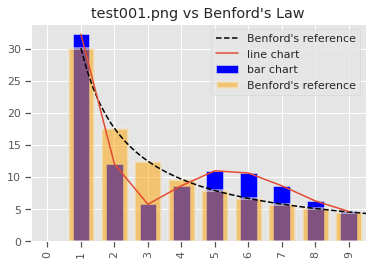

In [22]:
image_name_basename = os.path.basename(image_path_ground_thruth)
image_name = image_name_basename # os.path.splitext(image_name_basename)[0]

title = f'{image_name} vs Benford\'s Law'
digits_s = create_benford_graph(s, title= title)

In [23]:
# Compute Benford's law for Predicted Image.

image_path_pred = '/content/predicted_image.png'
# image_path_pred = '/content/predicted_image_grayscale.png' # '/content/predicted_image.png'

image_pred = Image.open(image_path_pred)

array_image_pred = np.asarray(image_pred)

print('Image shape', array_image_pred.shape)
print('Image\'s pixel min value', array_image_pred.min(), '\nImage\'s pixel max value', array_image_pred.max())

s_pred = pd.Series(array_image_pred.flat)

Image shape (480, 640, 4)
Image's pixel min value 1 
Image's pixel max value 255


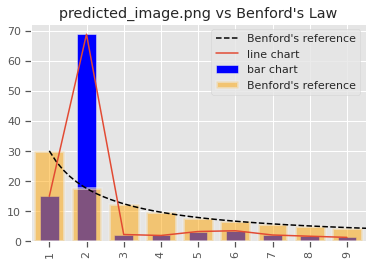

In [24]:
image_name_basename = os.path.basename(image_path_pred)
image_name = image_name_basename # os.path.splitext(image_name_basename)[0]

title = f'{image_name} vs Benford\'s Law'
digits_s_pred = create_benford_graph(s_pred, title = title)

In [25]:
# Compute Benford's law for Predicted Image as grayscale image in nature.

# image_path_pred_gs = '/content/predicted_image_grayscale.png'

image_pred = Image.open(image_path_pred_gs)
array_image_pred = np.asarray(image_pred)

print('Image shape', array_image_pred.shape)
print('Image\'s pixel min value', array_image_pred.min(), '\nImage\'s pixel max value', array_image_pred.max())

s_pred = pd.Series(array_image_pred.flat)

Image shape (480, 640)
Image's pixel min value 30 
Image's pixel max value 255


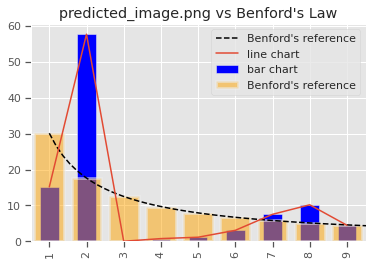

In [26]:
image_name_basename = os.path.basename(image_path_pred)
image_name = image_name_basename # os.path.splitext(image_name_basename)[0]

title = f'{image_name} vs Benford\'s Law'
digits_s_pred = create_benford_graph(s_pred, title = title)

#### Summary complex Images - Benford's Law

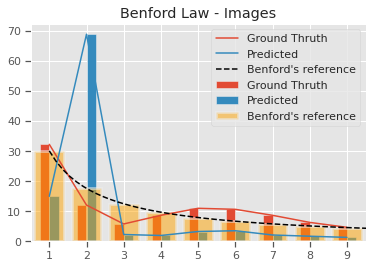

In [27]:
# image_path_ground_thruth = '/content/test001.png'
# image_path_pred = '/content/predicted_image.png'

image_a = Image.open(image_path_ground_thruth)
image_b = Image.open(image_path_pred)

_ = combine_images_benford(image_a, image_b)

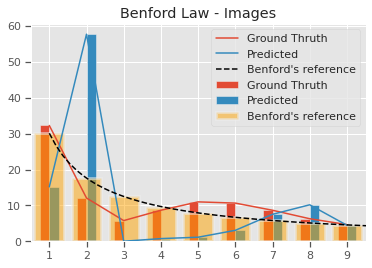

In [28]:
# Provide tow images and display combined benford's law graphics.
# image_path_pred_gs = '/content/predicted_image_grayscale.png'

image_a = Image.open(image_path_ground_thruth)
image_b = Image.open(image_path_pred_gs)

_ = combine_images_benford(image_a, image_b)

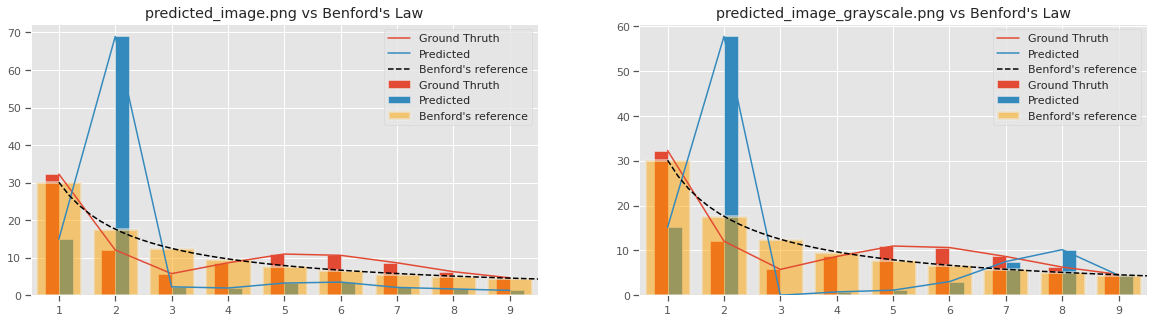

In [29]:
# Show two Benford's Law graphics for two images in the same
# plot complex.

fig, axes = plt.subplots(1, 2, figsize = (20, 5))

# Prepare first image.
image_path_ground_thruth = '/content/test001.png'
# image_path_pred = '/content/predicted_image.png'

image_a = Image.open(image_path_ground_thruth)
image_b = Image.open(image_path_pred)

combine_images_benford(image_a, image_b, ax = axes[0])

image_name_basename = os.path.basename(image_path_pred)
image_name = image_name_basename # os.path.splitext(image_name_basename)[0]
title = f'{image_name} vs Benford\'s Law'
axes[0].set_title(title)

# Prepare second image.
image_path_ground_thruth = '/content/test001.png'
# image_path_pred_gs = '/content/predicted_image_grayscale.png'

image_a = Image.open(image_path_ground_thruth)
image_b = Image.open(image_path_pred_gs)

combine_images_benford(image_a, image_b, ax = axes[1])

image_name_basename = os.path.basename(image_path_pred_gs)
image_name = image_name_basename # os.path.splitext(image_name_basename)[0]
title = f'{image_name} vs Benford\'s Law'
axes[1].set_title(title)

# Show Result.
plt.show()

## Final Remarks:

#### Last plot:
What we can observe or understand from looking at the graphics shown within the last picture is that both compressed images, that are *predicted_image_grayscale.png* and *predicted_image.png*, shown:
- an increas of occurences for those pixel intesity values that are either within the range $[20  30)$ or $[200, 256)$;
- while for the remaning occurences the compressed images show generally speaking a significant and important drop both w.r.t. ground thruth iamge that is, *test001.png*, and *Benford's Law reference*.